# Part 3) Method validation and find optimal thresholds

In this notebook, we use again the surrogate methods to validate our method and show how we would find optimal thresholds for the acceptance test.

In order to validate the methodology, we expand the surrogate simulation to all recorded spike trains and use the simulated calcium spine traces with their respective spike train as ground-truth monosynaptic connections. Similarly to Part 2, we can then obtain the GT-Rs and Test-Rs distributions. In addition to these, we introduce here a new surrogate distribution of R values named noGT-Rs, which is the distribution of R-values from the second-best match units. As we collect the distributions from all units, we denote them as GT-R-all, noGT-R-all, and Test-R-all.

Last, we apply a performence test using the GT-R-all and noGT-R-all to evaluate our method and explore the optimal thresholds. Our goal is to find two optimal quantile values for the Test-Rs and GT-Rs distributions, denoted as Q-test and Q-GT, respectively. 

We can use the pre-computed GT-R-all and noGT-R-all R-values to compute, for each tested quantile, the following values:

- number of true positives (#TP): surrogate tests that correctly identify the right best match from the GT-R-all distribution
- number of false negatives (#FN): surrogate tests that incorrectly don't find the right best match from the GT-R-all distribution
- number of true negatives (#TN): surrogate tests that correctly fails to identify a monosynaptic connection from the noGT-Rs distribution
- number of false positives (#FP): surrogate tests that incorrectly identify a monosynaptic connection from the noGT-R-all distribution

From these values, we can compute the F-score for different Q-test and Q-GT values and find the optimal values that yield the highest F-score.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import quantities as pq
import scipy.signal as ss
import scipy.stats as stats
import scipy.ndimage as ndimg
from joblib import Parallel, delayed
from pandas import DataFrame
import seaborn as sns
import sys

%matplotlib notebook

In [4]:
sys.path.append("..")
from imaging_tools import *

In [83]:
LOAD_DATA = True

In [5]:
# load nwb file
nwb_file_path = "../notebooks/recB1_chip2282.nwb"
_, imag, _, _, mea_duration, ds_idxs = load_nwb_file(nwb_file_path)

In [7]:
# Load saved variables
saved_var1 = np.load('saved_data_P1.npz',allow_pickle=True)
saved_var2 = np.load('saved_data_P2.npz',allow_pickle=True)

spiketrains = saved_var1['spiketrains']
best_match = saved_var1['best_match']
best_r = saved_var1['best_r']
individual_frs_ds_dff = saved_var1['individual_frs_ds_dff'] # convolved spike trains
keep = saved_var1['keep'] # indices to exclude network bursts

release_probs = saved_var2['release_probs'] # simulated release probablity
std_noise = saved_var2['std_noise'] # standard deviation of measure noise
std_signal = saved_var2['std_signal'] # standard deviation of signal (spine trace)
baseline_signal = saved_var2['baseline_signal'] # baseline

# 1. Generate GT surrogates for all recorded spike trains

First, we compute surrogates for all recorded spike trains with the simulated release probablity and measured noise as used in part2. 

In [84]:
# Compute surrogates or directly load from example data

n_surrogates = 1000 # number of surrogates

gt_surrogates_all = generate_surrogates(n_surrogates, imag.get_num_frames(), release_probs, spiketrains,best_match,
                                        ds_idxs, std_noise, std_signal, baseline_signal, 100, 25, method='GT_all')
timestamps = np.linspace(0, duration, len(gt_surrogates_all[0, 0]))

<IPython.core.display.Javascript object>


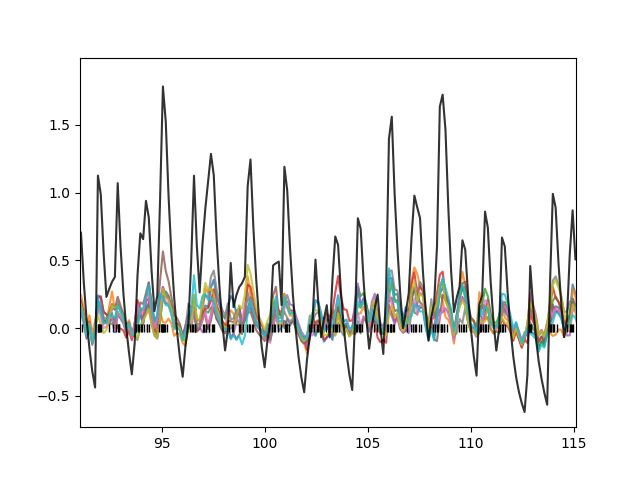

In [127]:
spike_id = best_match
plt.figure()
plt.plot(timestamps, gt_surrogates_all[spike_id, ::100, :].T, alpha=0.8)
plt.plot(timestamps, individual_frs_ds_dff[spike_id], color="k", alpha=0.8)
plt.plot(spiketrains[spike_id], np.zeros_like(spiketrains[spike_id]), "k", ls="", marker="|")

# 2. Compute GT-Rs and noGT-Rs
We then compute the distributions of GT-Rs and noGT-Rs for surrogates from all units.

In [87]:
# see function documentation for details
corr_r, GT_r_all, no_GT_r_all = compute_corr_r(gt_surrogates_all, n_surrogates, individual_frs_ds_dff, keep)

Computing correlation R: 100%|██████████| 78/78 [05:59<00:00,  4.61s/it]


# 3. Compute test-Rs

In [88]:
# see function documentation for details
n_jobs = 12 # number of workers for parallel computating
test_r_all = compute_test_r(gt_surrogates_all, n_surrogates, corr_r, individual_frs_ds_dff, keep, n_jobs)

# 4. Performance test

After computing all surrogate R-distributions, we can perform the acceptance test presented in part2 for each GT and noGT example, for different values of `Q_test` and `Q_gt`. To recap, a monosynaptic connection is accepted is the R-value between the convolved spike train and the spine trace (in this case simulated) is above both the R-value thresholds given by these quantiles from the Test-Rs and GT-Rs distribitions, respectively.

After computing #TP, #FN, #TN and #FP, we use them to calculate the F-score, that we use as performance metric for each pair of (`Q_test`, `Q_gt`) values.

In [44]:
# two threholds for accepting a mapped functional synaptic connection
# Q_test: Q threshold on test-Rs
# Q_gt: Q threshold on GT_Rs (R need to be within)

N_values = 100 # number of quantile values
Q_test = np.round(np.linspace(0, 1, N_values, endpoint=True), decimals=3) # percentile value
Q_gt = np.round(np.linspace(0, 1, N_values, endpoint=True), decimals=3)

conf_matrix = []

for r in Q_test:
    for q in Q_gt:
        TP = 0
        FN = 0
        FP = 0
        TN = 0
        matrix = []

        for i in range(len(spiketrains)):
            gt_rs = corr_r[i, :, i]            
            
            r1 = np.nanquantile(np.concatenate(test_r_all[i]), r) 
            r2 = np.nanquantile(gt_rs, q)
            
            tp = len(np.where(GT_r_all[i][np.isfinite(GT_r_all[i])] > max(r1, r2))[0])
            fn = len(GT_r_all[i]) - tp
            fp = len(np.where(no_GT_r_all[i] > max(r1, r2))[0])
            tn = len(no_GT_r_all[i]) - fp

            TP = tp + TP
            FN = fn + FN
            FP = fp + FP
            TN = tn + TN

        matrix.extend([TP,FN,FP,TN])
        conf_matrix.append(matrix)

In [175]:
# compute evaluation terms from confusion matrix
precision = []
recall = []

for i in conf_matrix:
    tp, fn, fp, tn = i
#     print(tp, fn)
    recall.append(tp / (tp + fn))
    
    if (tp + fp) != 0:
        precision.append(tp / (tp + fp))
    else:
        precision.append(np.nan)   

# reshape evaluation terms
precision = np.array(precision).reshape(N_values, N_values)
recall = np.array(recall).reshape(N_values, N_values)

beta = 0.5 # factor to calculate F-score
F_score = (1 + np.square(beta))*precision*recall/(np.square(beta)*precision + recall)

/net/bs-filesvr01/export/group/hierlemann/spikesorting/miniconda3/envs/imaging/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


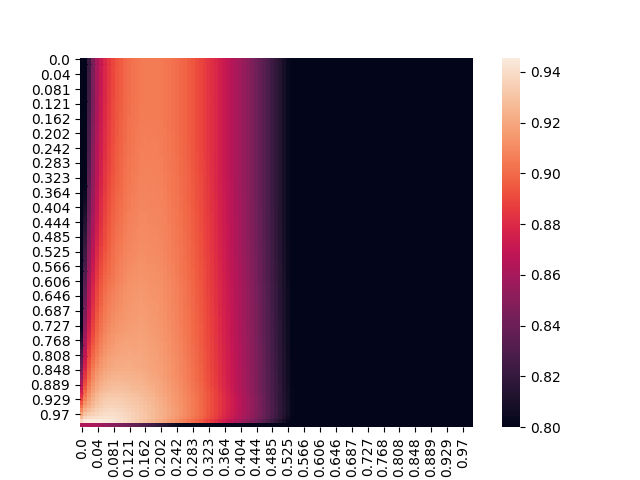

0.9456347937320114


In [176]:
# heatmap of F-score

df = DataFrame(F_score, index=Q_test, columns=Q_gt)
fig=plt.figure()
ax = sns.heatmap(df)
print(np.nanmax(F_score))

In [80]:
# get the thresholds with maximum F-score

optimal_Q_test = Q_test[np.where(F_score == np.nanmax(F_score))[0]]
optimal_Q_gt = Q_gt[np.where(F_score == np.nanmax(F_score))[1]]

In [101]:
print("Q_gt:", optimal_Q_gt)
print("Q_test:", optimal_Q_test)
print("max F-score:", np.nanmax(F_score))

Q_gt: [0.061]
Q_test: [0.99]
max F-score: 0.957581278824802
